# Tutorial 1: Generalization and representational geometry

**Week 1, Day 3: Comparing artificial and biological neural networks**

**By Neuromatch Academy**

__Content creators:__ JohnMark Taylor & Zhuofan Josh Ying

__Content reviewers:__ Names & Surnames

__Production editors:__ Names & Surnames

<br>

Acknowledgments: [ACKNOWLEDGMENT_INFORMATION]


# Tutorial 1: Generalization and representational geometry

Estimated timing of tutorial: 30 minutes

Welcome to Tutorial 1 on Generalization and Representational Geometry. This tutorial aims to bridge the gap between theoretical concepts and practical applications in machine learning, focusing on the relationship between generalization and condition similarities based on linear models. By the end of this tutorial, you will:

- Understand the connection between generalization and condition similarities in the linear case, including a nod towards the kernel trick discussed in lectures.
- Understand how the analytic solution for linear regression can be seen as a weighted sum of training values, weighted by the test stimuli’s similarity to the training data.

Exercises:
1.   Question on comparing RDMs
2.   Question on the relationship between RDMs and model performances
3.   Interactive exercise on how similarity structure affects predictions



In [1]:
# @title Tutorial slides
# @markdown These are the slides for the videos in all tutorials today

# from IPython.display import IFrame
#link_id = "<YOUR_LINK_ID_HERE>"
# print(f"If you want to download the slides: https://osf.io/download/{link_id}/")
#IFrame(src=f"https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{link_id}/?direct%26mode=render", width=854, height=480)

---
# Setup



In [2]:
# @title Install dependencies
#! pip install ipympl ipywidgets mpl_interactions["jupyter"] rsatoolbox torchlens
#! pip install graphviz

# To install jupyter-matplotlib (ipympl) via pip
!pip install ipympl

# To install jupyter-matplotlib via conda (comment out if you are not using conda)
# !conda install -c conda-forge ipympl

# To install the JupyterLab extension for ipywidgets
!jupyter labextension install @jupyter-widgets/jupyterlab-manager

# To install the JupyterLab extension for jupyter-matplotlib
!jupyter labextension install jupyter-matplotlib

(Deprecated) Installing extensions with the jupyter labextension install command is now deprecated and will be removed in a future major version of JupyterLab.

Users should manage prebuilt extensions with package managers like pip and conda, and extension authors are encouraged to distribute their extensions as prebuilt packages 
/home/samuele/virtualenvs/neuroaienv/lib/python3.9/site-packages/jupyterlab/debuglog.py:56: UserWarning: An error occurred.
  warnings.warn("An error occurred.")
/home/samuele/virtualenvs/neuroaienv/lib/python3.9/site-packages/jupyterlab/debuglog.py:57: UserWarning: ValueError: Please install Node.js and npm before continuing installation. You may be able to install Node.js from your package manager, from conda, or directly from the Node.js website (https://nodejs.org).
  warnings.warn(msg[-1].strip())
/home/samuele/virtualenvs/neuroaienv/lib/python3.9/site-packages/jupyterlab/debuglog.py:58: UserWarning: See the log file for details: /tmp/jupyterlab-debug-pj

In [3]:
# @title Import dependencies

import ipywidgets as widgets
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnnotationBbox, OffsetImage
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.metrics.pairwise import linear_kernel
import torch
from torchvision import transforms, datasets
import torchlens as tl
import warnings

from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
from collections import OrderedDict

%matplotlib inline
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
import numpy as np

import torchlens as tl

import rsatoolbox
from rsatoolbox.data import Dataset
from rsatoolbox.rdm.calc import calc_rdm
from scipy import stats

import logging

In [4]:
# @title Figure settings
# @markdown

logging.getLogger('matplotlib.font_manager').disabled = True

%matplotlib inline
%config InlineBackend.figure_format = 'retina' # perfrom high definition rendering for images and plots
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/main/nma.mplstyle")

In [5]:
# @title Plotting functions


## Section 1: MNIST DNN Comparisons

In this activity, you will use linear regression on representations of two neural networks trained on MNIST, one with adversarial training and one without. The objective is to observe:

- How predictions for clean images of numbers are similar for a deep layer and closely align with the category structure.
- The similarity matrix reflects a category structure and how matrices from the two networks compare.
- The significant differences in predictions and similarity matrices when applying adversarial examples.

### Understanding the MNIST DNNs

We start by defining and training two models on the MNIST dataset: a standard model and an adversarially robust model. The training process includes a step where adversarial examples are generated and used to train the robust model, providing an insight into how adversarial training influences model behavior.

**Defining the MNIST Model**

First, we define a neural network model that will be trained on the MNIST dataset. The MNIST dataset consists of 28x28 pixel images of handwritten digits (0 through 9). Our model, based on the LeNet architecture, includes two convolutional layers followed by dropout layers to reduce overfitting, and finally, fully connected layers to perform classification.

In [7]:
# modified and reorganized from https://github.com/pytorch/examples/blob/main/mnist/main.py

#lenet model
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

def train_one_epoch(args, model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            if args.dry_run:
                break

def test(model, device, test_loader, return_features=False):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

def build_args():
    # Training settings
    parser = argparse.ArgumentParser(description='PyTorch MNIST Example')
    parser.add_argument('--batch-size', type=int, default=64, metavar='N',
                        help='input batch size for training (default: 64)')
    parser.add_argument('--test-batch-size', type=int, default=1000, metavar='N',
                        help='input batch size for testing (default: 1000)')
    parser.add_argument('--epochs', type=int, default=2, metavar='N',
                        help='number of epochs to train (default: 14)')
    parser.add_argument('--lr', type=float, default=1.0, metavar='LR',
                        help='learning rate (default: 1.0)')
    parser.add_argument('--gamma', type=float, default=0.7, metavar='M',
                        help='Learning rate step gamma (default: 0.7)')
    parser.add_argument('--no-cuda', action='store_true', default=False,
                        help='disables CUDA training')
    parser.add_argument('--no-mps', action='store_true', default=False,
                        help='disables macOS GPU training')
    parser.add_argument('--dry-run', action='store_true', default=False,
                        help='quickly check a single pass')
    parser.add_argument('--seed', type=int, default=1, metavar='S',
                        help='random seed (default: 1)')
    parser.add_argument('--log-interval', type=int, default=50, metavar='N',
                        help='how many batches to wait before logging training status')
    parser.add_argument('--save-model', action='store_true', default=False,
                        help='For Saving the current Model')
    args = parser.parse_args('')

    use_cuda = torch.cuda.is_available() #not args.no_cuda and
    use_mps = not args.no_mps and torch.backends.mps.is_available()

    if use_cuda:
        device = torch.device("cuda")
    elif use_mps:
        device = torch.device("mps")
    else:
        device = torch.device("cpu")

    args.use_cuda = use_cuda
    args.device = device
    return args

def fetch_dataloaders(args):

    train_kwargs = {'batch_size': args.batch_size}
    test_kwargs = {'batch_size': args.test_batch_size}
    if args.use_cuda:
        cuda_kwargs = {'num_workers': 1,
                       'pin_memory': True,
                       'shuffle': True}
        train_kwargs.update(cuda_kwargs)
        test_kwargs.update(cuda_kwargs)

    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
        ])
    dataset1 = datasets.MNIST('../data', train=True, download=True,
                       transform=transform)
    dataset2 = datasets.MNIST('../data', train=False,
                       transform=transform)
    train_loader = torch.utils.data.DataLoader(dataset1,**train_kwargs)
    test_loader = torch.utils.data.DataLoader(dataset2, **test_kwargs)
    return train_loader, test_loader

def train_model(args, model, optimizer):
    scheduler = StepLR(optimizer, step_size=1, gamma=args.gamma)
    for epoch in range(1, args.epochs + 1):
        train_one_epoch(args, model, args.device, train_loader, optimizer, epoch)
        test(model, args.device, test_loader)
        scheduler.step()

    if args.save_model:
        torch.save(model.state_dict(), "mnist_cnn.pt")

**Training the Standard Model**

Once our model is defined, we proceed to train it on the MNIST dataset. Training involves feeding batches of images and their corresponding labels to the model, adjusting the model's weights based on the loss computed from its predictions and the actual labels. This process is iterated over multiple epochs to improve the model's accuracy.

In [8]:
# build and train the model

args = build_args()
torch.manual_seed(args.seed)
train_loader, test_loader = fetch_dataloaders(args)

# build_model
model = Net().to(args.device)

print(model)
optimizer = optim.Adadelta(model.parameters(), lr=args.lr)

# train model
train_model(args, model, optimizer) #train the model for 2 epochs ~ %99 accuracy ~ 30 sec colab gpu

# alternative, grab a pretrained model from some place
# pretrained_model = "{link}/lenet_mnist_model.pth"
# model.load_state_dict(torch.load(pretrained_model, map_location=args.device))

Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout(p=0.25, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)
Train Epoch: 1 [0/60000 (0%)]	Loss: 2.284250
Train Epoch: 1 [3200/60000 (5%)]	Loss: 0.473057
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.316132
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.055055
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.072602
Train Epoch: 1 [16000/60000 (27%)]	Loss: 0.383906
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.196070
Train Epoch: 1 [22400/60000 (37%)]	Loss: 0.202771
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.199297
Train Epoch: 1 [28800/60000 (48%)]	Loss: 0.037032
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.284828
Train Epoch: 1 [35200/60000 (59%)]	Loss: 0.080580
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.126560
Train Epoch: 1 [41

**Generating Adversarial Examples**

Adversarial examples are inputs to machine learning models that an attacker has intentionally designed to cause the model to make a mistake. They are often **indistinguishable** from real data by humans but result in incorrect predictions by the model. Generating these examples and using them in training can improve a model's robustness.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


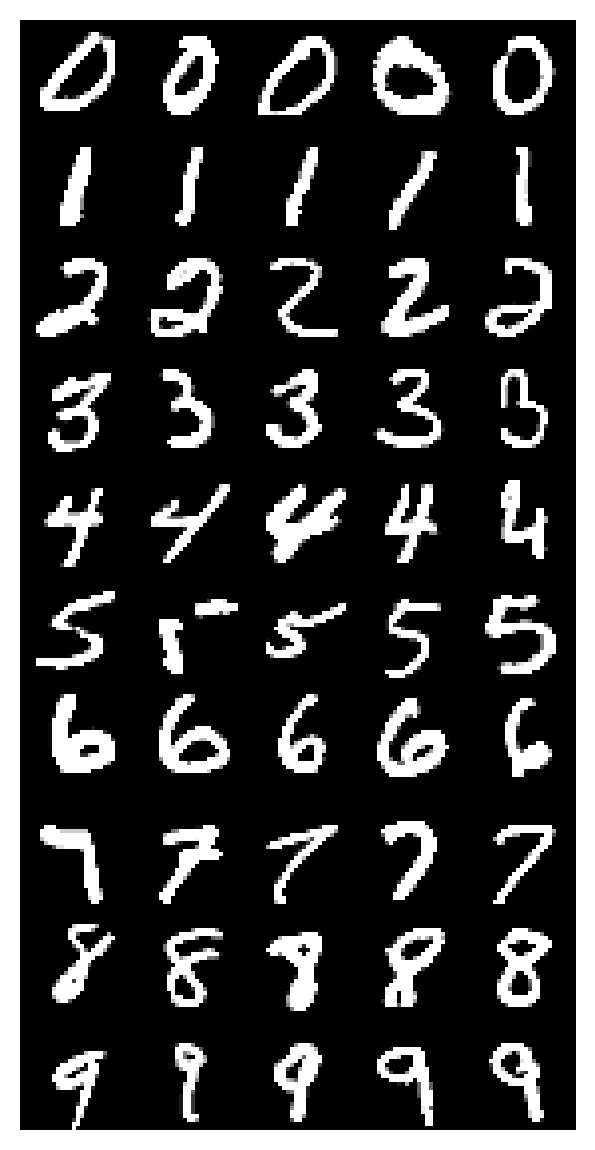

In [9]:
# grab 5 test images from each category and visualize them

def sample_images(data_loader, n=5, plot=False):

    imgs, labels = next(iter(data_loader))

    imgs_o = []
    targets = []
    for value in range(10):
        imgs_o.append(imgs[np.where(labels == value)][0:n])
        targets.append([value]*5)

    imgs = torch.cat(imgs_o, dim=0)
    targets = torch.tensor(targets).flatten()

    if plot:
        plt.imshow(torch.moveaxis(make_grid(imgs, nrow=5, padding=0, normalize=False, pad_value=0), 0,-1))
        plt.axis('off')

    return imgs, targets

imgs, targets = sample_images(test_loader, n=5, plot = True)

In [10]:
# modified from https://pytorch.org/tutorials/beginner/fgsm_tutorial.html

# generating adversarial images using FGSM attack

# FGSM attack code
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image

# restores the tensors to their original scale
def denorm(batch, mean=[0.1307], std=[0.3081]):
    """
    Convert a batch of tensors to their original scale.

    Args:
        batch (torch.Tensor): Batch of normalized tensors.
        mean (torch.Tensor or list): Mean used for normalization.
        std (torch.Tensor or list): Standard deviation used for normalization.

    Returns:
        torch.Tensor: batch of tensors without normalization applied to them.
    """
    if isinstance(mean, list):
        mean = torch.tensor(mean).to(batch.device)
    if isinstance(std, list):
        std = torch.tensor(std).to(batch.device)

    return batch * std.view(1, -1, 1, 1) + mean.view(1, -1, 1, 1)

def generate_adversarial(model, imgs, targets, epsilon):

    # Accuracy counter
    correct = 0
    adv_imgs = []

    # Loop over all examples in test set
    for img, target in zip(imgs, targets):

        img = img.unsqueeze(0)
        target = target.unsqueeze(0)
        # Set requires_grad attribute of tensor. Important for Attack
        img.requires_grad = True

        # Forward pass the data through the model
        output = model(img)
        init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability

        # Calculate the loss
        loss = F.nll_loss(output, target)

        # Zero all existing gradients
        model.zero_grad()

        # Calculate gradients of model in backward pass
        loss.backward()

        # Collect ``datagrad``
        data_grad = img.grad.data

        # Restore the data to its original scale
        data_denorm = denorm(img)

        # Call FGSM Attack
        perturbed_data = fgsm_attack(data_denorm, epsilon, data_grad)

        # Reapply normalization
        perturbed_data_normalized = transforms.Normalize((0.1307,), (0.3081,))(perturbed_data)

        adv_imgs.append(perturbed_data_normalized.detach())

    return torch.cat(adv_imgs)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 139.5, 279.5, -0.5)

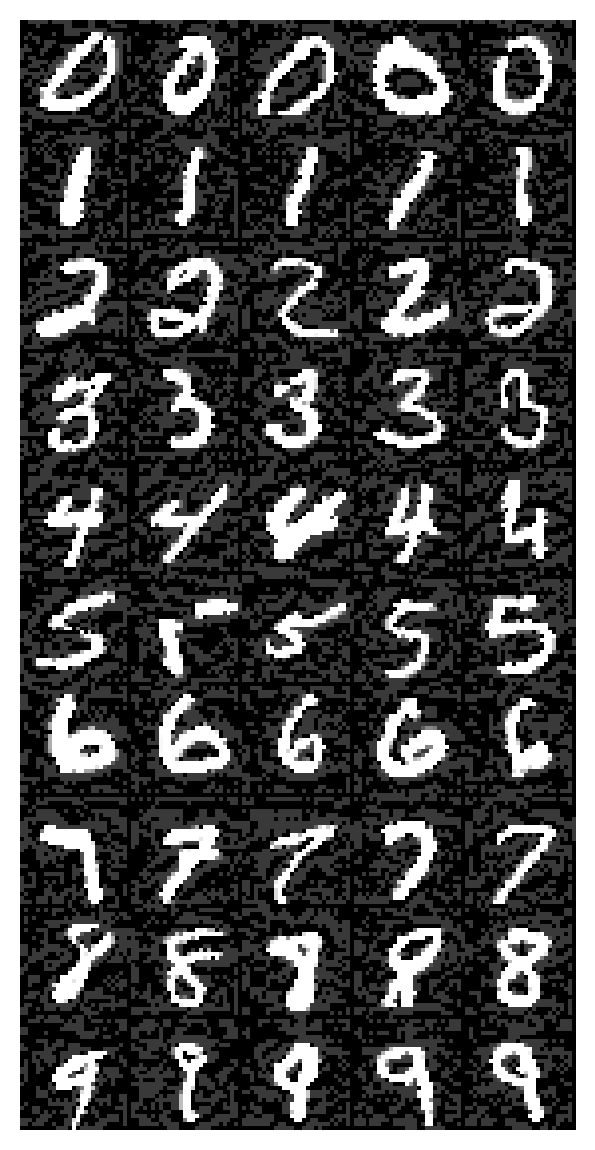

In [11]:
# Generate adversarial images for the standard model

# Set random seed for reproducibility
torch.manual_seed(42)
eps = 0.2
imgs =imgs.to(args.device)
targets = targets.to(args.device)

adv_imgs = generate_adversarial(model, imgs, targets, eps)
adv_imgs.shape

plt.imshow(torch.moveaxis(make_grid(adv_imgs.cpu(), nrow=5, padding=0, normalize=False, pad_value=0), 0,-1))
plt.axis('off')

**Training the Adversarially Robust Model**

With adversarial examples at hand, we now train a model designed to be robust against such examples. The idea is to include adversarial examples in the training process, enabling the model to learn from and defend against them.

In [12]:
# Train the model to be robust to adversarial attack

def train_one_epoch_adversarial(args, model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        # train the model on adversarial images
        epsilon = 0.2
        data = generate_adversarial(model, data, target, epsilon)

        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            if args.dry_run:
                break

def train_model_adversarial(args, model, optimizer):
    scheduler = StepLR(optimizer, step_size=1, gamma=args.gamma)
    for epoch in range(1, args.epochs + 1):
        train_one_epoch_adversarial(args, model, args.device, train_loader, optimizer, epoch)
        test(model, args.device, test_loader)
        scheduler.step()

    if args.save_model:
        torch.save(model.state_dict(), "robust_mnist_cnn.pt")

In [13]:
# train adversirally robust model
import time
start_time = time.time()
model_robust = Net().to(args.device)
print(model)
optimizer = optim.Adadelta(model_robust.parameters(), lr=args.lr)

train_model_adversarial(args, model_robust, optimizer) #train the model for 2 epochs ~ %98 accuracy ~ 2 minutes on cpu

end_time = time.time()

# Calculate the total time taken and print it
elapsed_time = end_time - start_time
print(f"Training completed in {elapsed_time:.2f} seconds.")

Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout(p=0.25, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)
Train Epoch: 1 [0/60000 (0%)]	Loss: 2.359734
Train Epoch: 1 [3200/60000 (5%)]	Loss: 1.196956
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.212789
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.722739
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.642074
Train Epoch: 1 [16000/60000 (27%)]	Loss: 0.447824
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.252337
Train Epoch: 1 [22400/60000 (37%)]	Loss: 0.347889
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.372752
Train Epoch: 1 [28800/60000 (48%)]	Loss: 0.424232
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.505384
Train Epoch: 1 [35200/60000 (59%)]	Loss: 0.469727
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.294531
Train Epoch: 1 [41

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 139.5, 279.5, -0.5)

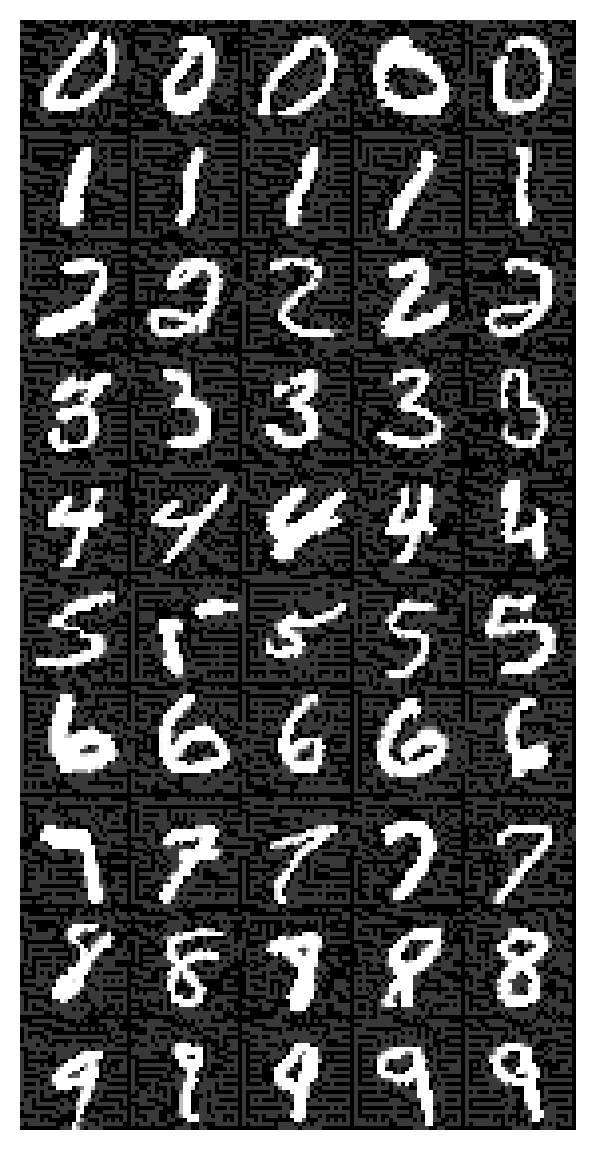

In [14]:
# Generate adversarial images for the adversarially trained model

# Set random seed for reproducibility
torch.manual_seed(42)
eps = 0.2
imgs =imgs.to(args.device)
targets = targets.to(args.device)

adv_imgs_advmodel = generate_adversarial(model_robust, imgs, targets, eps)
adv_imgs_advmodel.shape

plt.imshow(torch.moveaxis(make_grid(adv_imgs_advmodel.cpu(), nrow=5, padding=0, normalize=False, pad_value=0), 0,-1))
plt.axis('off')

**Evaluating Model Robustness**

After training, it's essential to evaluate how well the models perform, particularly in the presence of adversarial examples. We do this by testing the models on both standard and adversarial images and comparing their accuracies.

Note that these adversarially generated images are indistinguishable from the real ones, but they decrease standard model performances dramatically (as shown below). Adversarially trained model is robust to this kind of attack.

In [15]:
def test_adversarial(model, imgs, targets, plot=False):

    # Accuracy counter
    correct = 0
    adv_examples = []

    output = model(imgs)

    pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(targets.view_as(pred)).sum().item()

    final_acc = correct/float(len(imgs))
    print(f"adversarial test accuracy = {correct} / {len(imgs)} = {final_acc}")

    if plot:
        cnt = 0
        epsilons = [0.2]
        plt.figure(figsize=(8,10))
        for i in range(10):
            for j in range(5):

                plt.subplot(10,5,cnt+1)
                plt.xticks([], [])
                plt.yticks([], [])
                # if j == 0:
                #     plt.ylabel(f"Eps: {epsilons[i]}", fontsize=14)
                orig,adv,ex = targets[cnt].cpu().numpy(), pred[cnt].cpu().numpy(), imgs[cnt].moveaxis(0,-1).cpu()
                if orig == adv:
                    plt.title(f"{orig} -> {adv}")
                else:
                    plt.title(f"{orig} -> {adv}", fontweight="bold")

                plt.imshow(ex, cmap="gray")
                cnt += 1
        plt.tight_layout()
        plt.show()

print("For standard model trained without adversarial examples:")
test_adversarial(model, adv_imgs, targets, plot=False)
# test_adversarial(model_robust, adv_imgs, targets, plot=False)
print("For adversrially trained model:")
test_adversarial(model_robust, adv_imgs_advmodel, targets, plot=False)

For standard model trained without adversarial examples:
adversarial test accuracy = 20 / 50 = 0.4
For adversrially trained model:
adversarial test accuracy = 44 / 50 = 0.88


## Extracting Model Features and Analyzing Representations

With the models trained and adversarial images generated, we proceed to extract features from different layers of our networks using [torchlens](https://github.com/johnmarktaylor91/torchlens), a package for extracting neural network activations and visualizing their computational graph.  This step is crucial for understanding how data representations differ across layers and models, especially under adversarial conditions.

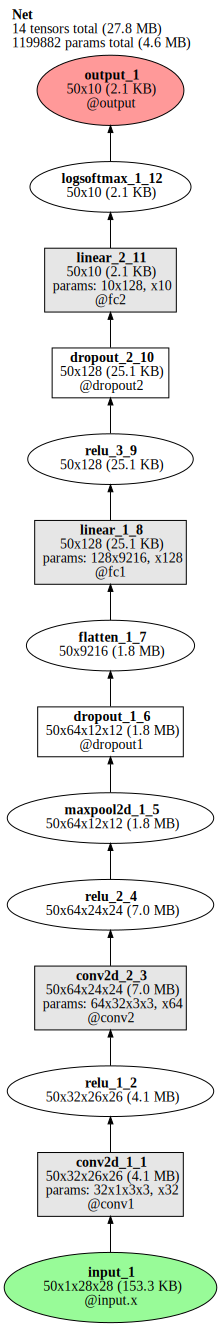

In [16]:
# extract model features with torchlens

def extract_features(model, imgs, return_layers, plot ='none'):

    model_history = tl.log_forward_pass(model, imgs, layers_to_save='all', vis_opt=plot)
    model_features = {}
    for layer in return_layers:
        model_features[layer] = model_history[layer].tensor_contents.flatten(1)

    return model_features


return_layers = ['input_1', 'conv1', 'conv2', 'fc1', 'fc2']
features_model_imgs = extract_features(model, imgs, return_layers, plot = 'rolled')

In [17]:
features_model_advimgs = extract_features(model, adv_imgs, return_layers)
features_advmodel_imgs = extract_features(model_robust, imgs, return_layers)
features_advmodel_advimgs = extract_features(model_robust, adv_imgs_advmodel, return_layers)

### Creating and Comparing Representation Similarity Matrices
Using the RSA toolbox, you will create representation similarity matrices (RSMs) for each model and condition (standard and adversarial). These matrices provide a visual representation of how stimuli are represented within the network, offering insights into the models' generalization capabilities and the effects of adversarial training.



In [18]:
# create the representationl similarity matrices using RSA toolbox

def calc_rdms(model_features, method='correlation'):
    ds_list = []
    for l in range(len(model_features)):

        layer = list(model_features.keys())[l]
        feats = model_features[layer]

        if type(feats) is list:
            feats = feats[-1]

        if args.use_cuda:
            feats = feats.cpu()

        if len(feats.shape)>2:
            feats = feats.flatten(1)

        feats = feats.detach().numpy()
        # feats = stats.zscore(feats)

        ds = Dataset(feats, descriptors=dict(layer=layer))
        ds_list.append(ds)

    rdms = calc_rdm(ds_list, method=method)

    rdms_dict = {list(model_features.keys())[i]: rdms.get_matrices()[i] for i in range(len(model_features))}

    return rdms, rdms_dict

def plot_maps(model_features):

    fig = plt.figure(figsize=(15, 4))
    # and we add one plot per reference point
    gs = fig.add_gridspec(1, len(model_features))
    fig.subplots_adjust(wspace=0.2, hspace=0.2)

    for l in range(len(model_features)):

        layer = list(model_features.keys())[l]
        map_ = np.squeeze(model_features[layer])

        if len(map_.shape) < 2:
            map_ = map_.reshape( (int(np.sqrt(map_.shape[0])), int(np.sqrt(map_.shape[0]))) )

        map_ = map_ / np.max(map_)

        ax = plt.subplot(gs[0,l])
        ax_ = ax.imshow(map_, cmap='magma_r')
        ax.set_title(f'{layer}')

    fig.subplots_adjust(right=0.9)
    cbar_ax = fig.add_axes([1, 0.15, 0.01, 0.7])
    fig.colorbar(ax_, cax=cbar_ax)

    plt.show()

/home/samuele/virtualenvs/neuroaienv/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


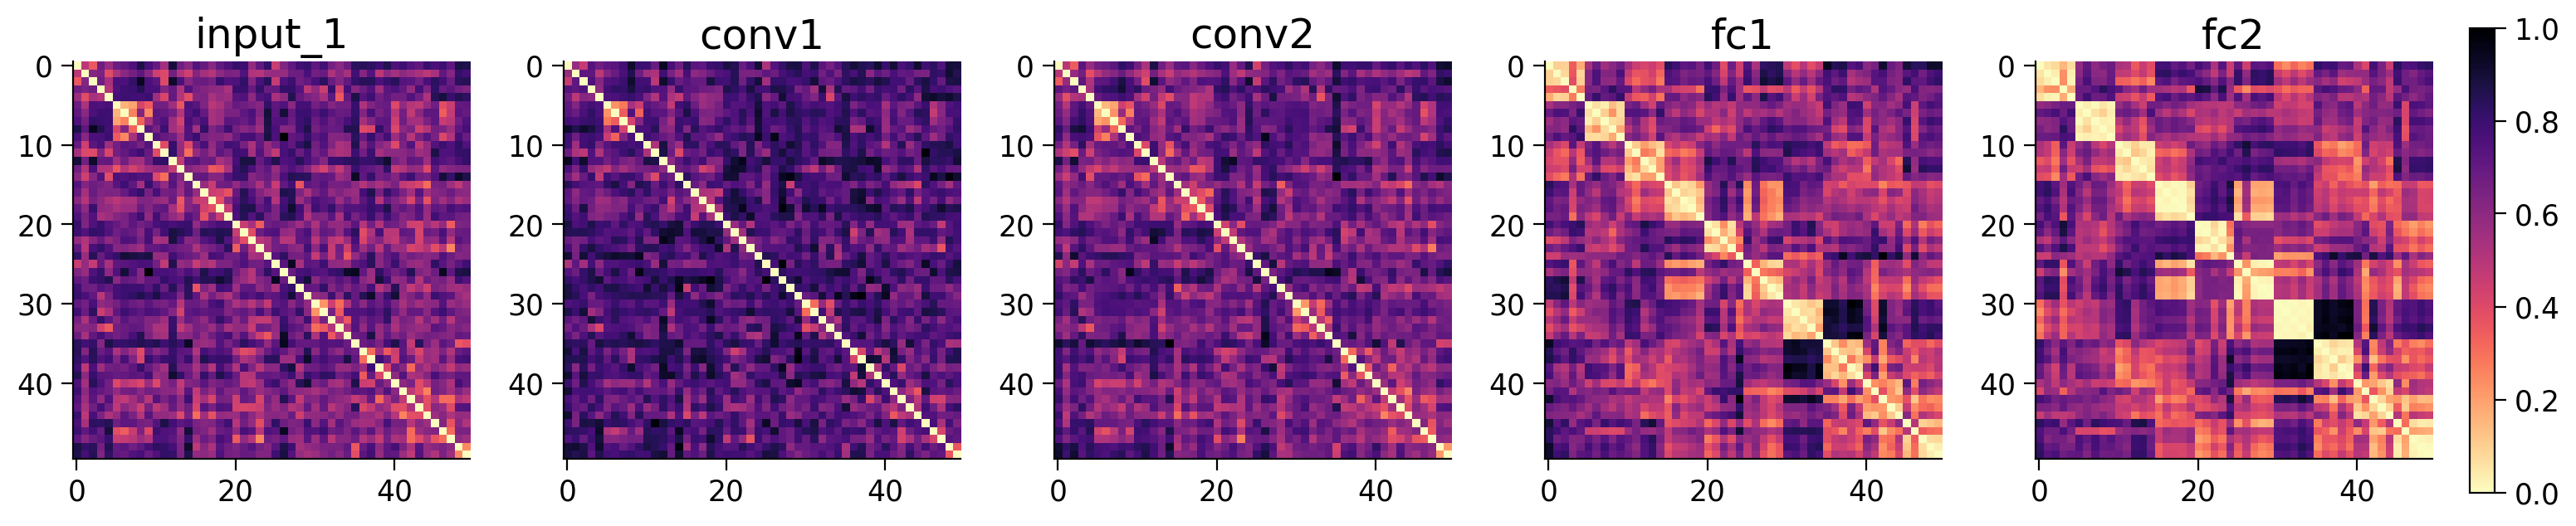

In [19]:
# for standard model + standard images
rdms, rdms_dict = calc_rdms(features_model_imgs)
plot_maps(rdms_dict)

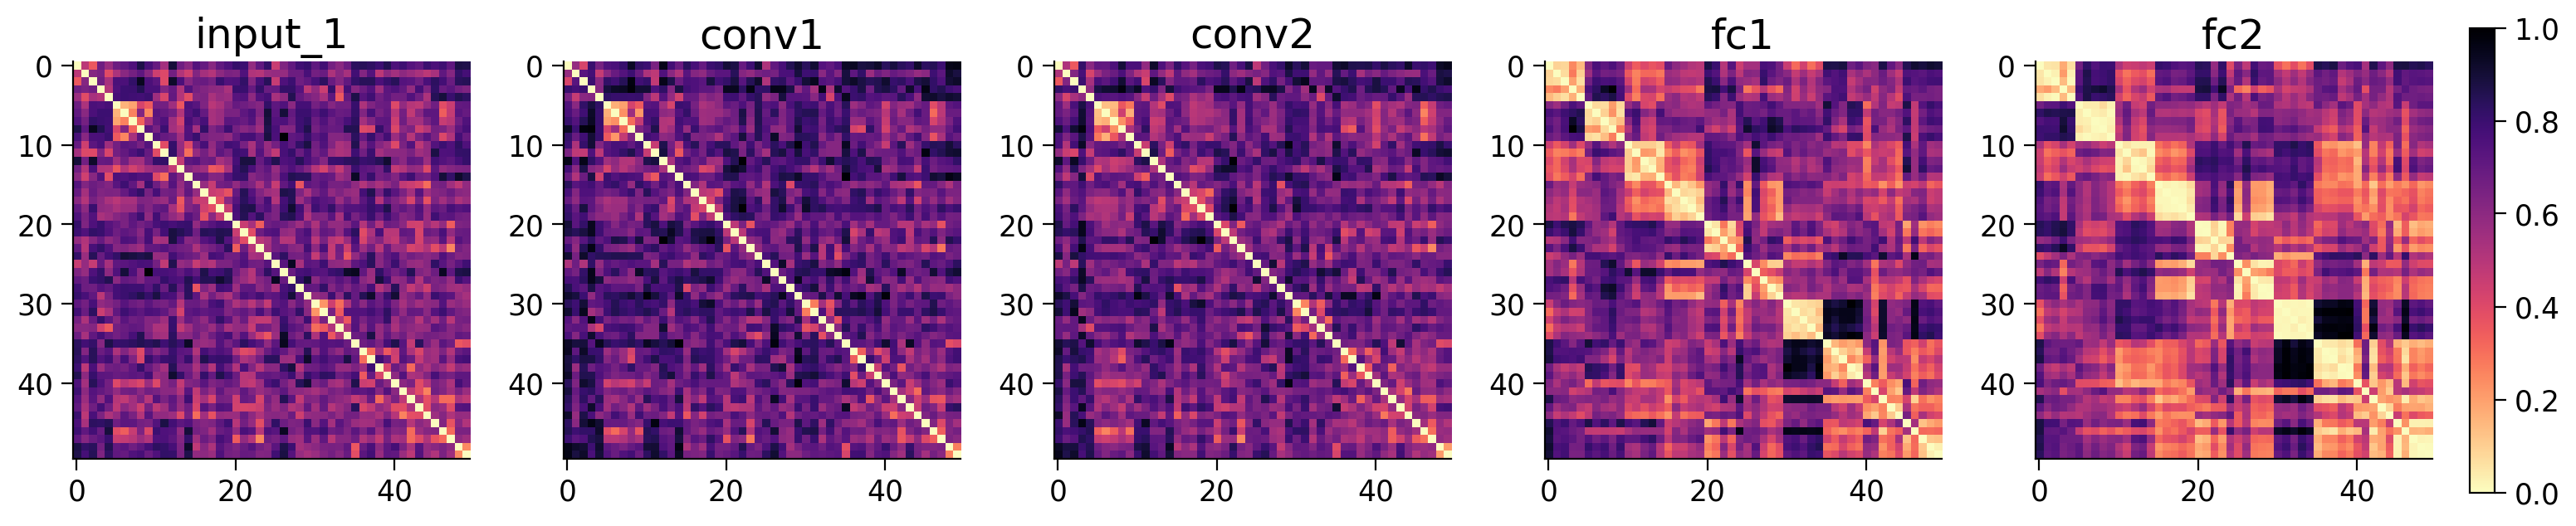

In [20]:
# for adversarially trained model + standard images
rdms, rdms_dict = calc_rdms(features_advmodel_imgs)
plot_maps(rdms_dict)

**Question**: For clean images, how do the RDMs change across the model layers, and why?


**Answer**: For clean images representing the same digit, their representations in the deeper layers of the network are remarkably similar and align well with the inherent category structure, manifesting as a distinct block effect. In contrast, this block effect is less pronounced in the earlier layers of the network. The initial layers focus more on capturing general and granular visual features. This progression from generic to more refined feature extraction across layers underscores the hierarchical nature of learning in deep neural networks, where complex representations are built upon the simpler ones extracted at earlier stages.

RDMs of the standard model and the adversarially trained model are very similar for clean images.

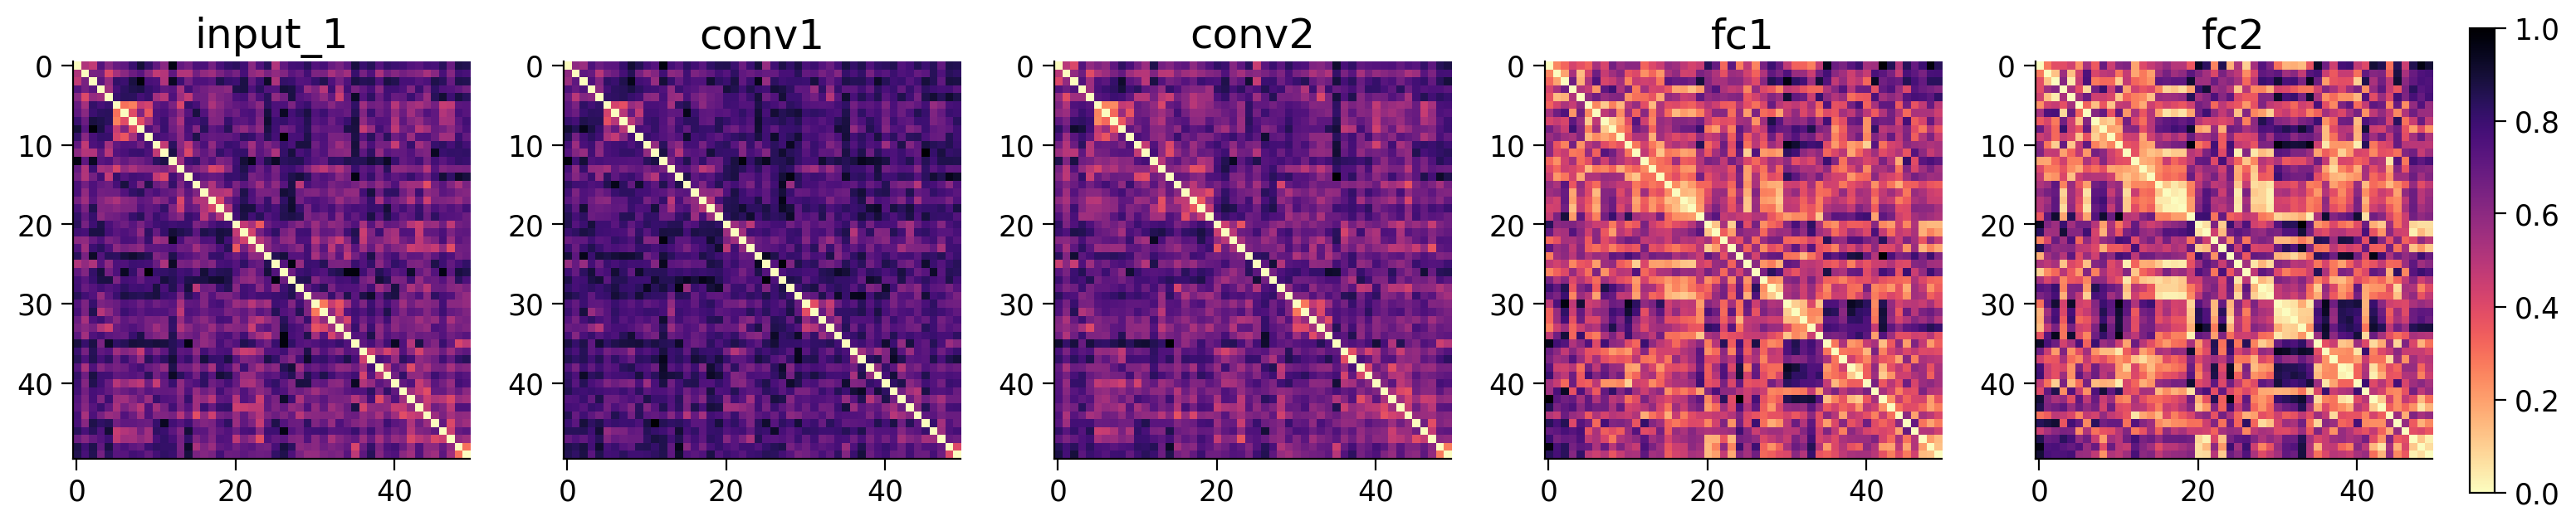

In [21]:
# for standard model + adversarial images
rdms, rdms_dict = calc_rdms(features_model_advimgs)
plot_maps(rdms_dict)

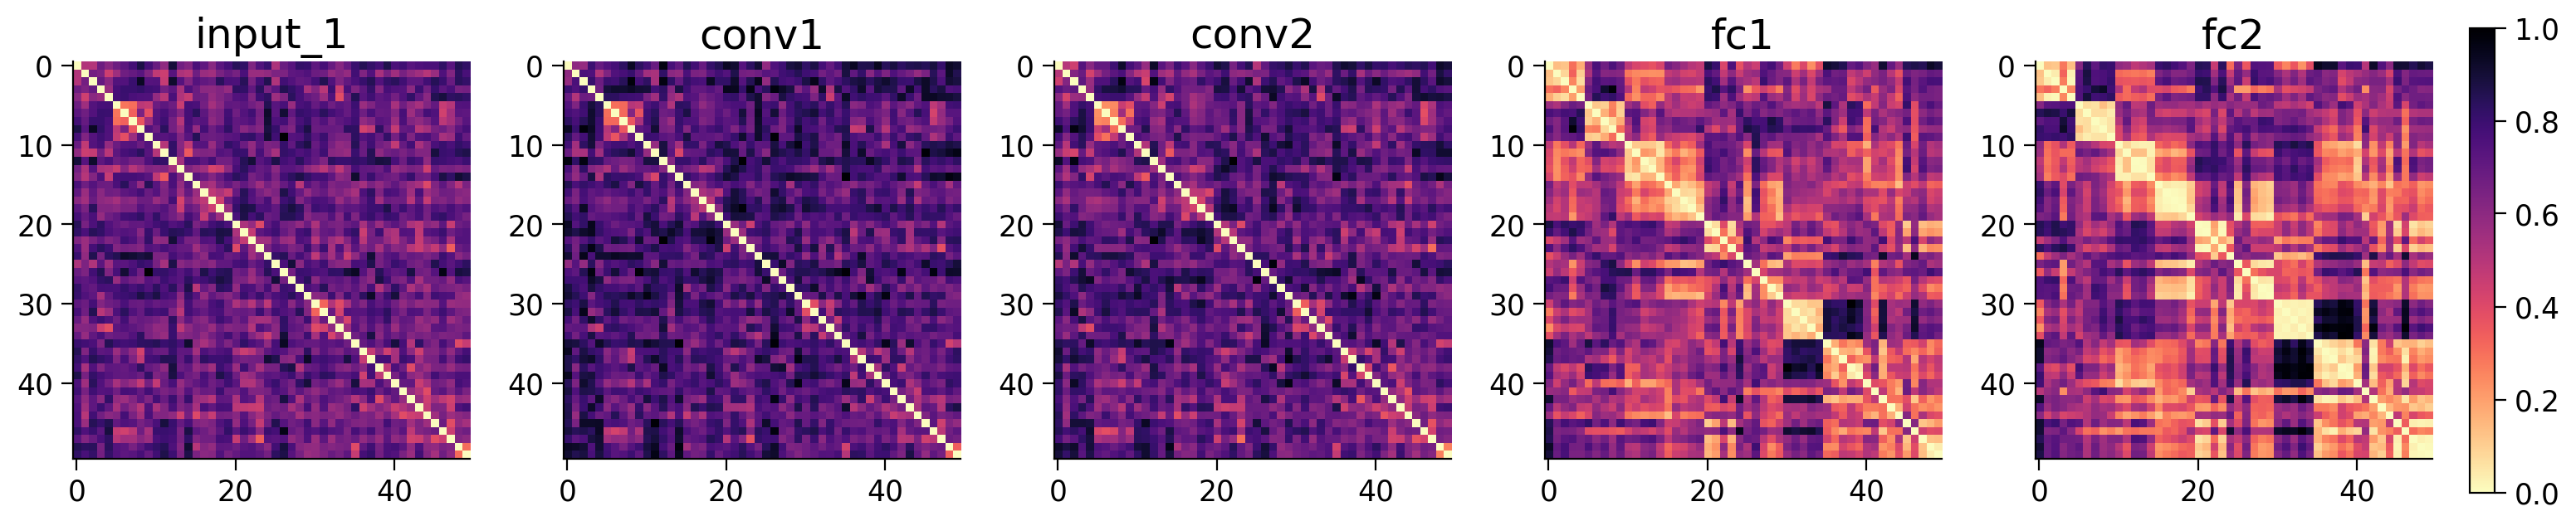

In [22]:
# for adversarially trained model + adversarial images
rdms, rdms_dict = calc_rdms(features_advmodel_advimgs)
plot_maps(rdms_dict)

**Question**: For adversarial images, how do the RDMs change when comparing representations from the standard model to the adversarially trained model?


**Answer**: Note for adversarial images, the representation similarity of the standard model within each category (the block effect) is notably disrupted in the deeper layers.

Conversely, for the adversarially trained model, despite the introduction of adversarial examples, the representation similarity matrix for preserves its block-like structure across categories.

**Question**: How does the RDMs relate to the performances of the standard and the adversarially trained models on clean and adversarial images?


**Answer**: RDMs provide a visual and quantitative way to analyze how a neural network processes and represents different stimuli. By comparing the similarity of responses within the network across various inputs, the RSM can reveal significant insights into the network's internal representations and, consequently, its ability to generalize.

Both the standard and the adversarially trained models show clear, distinct blocks in the RSM when inputs from the same category are represented similarly (high intra-class similarity) and inputs from different categories are distinct (low inter-class similarity). This differentiation is crucial for the model to achieve high accuracies on unseen test data from the same distribution.

However, for adversarial images, the block effect of the standard model is notably disrupted. This disruption correlates with a diminished test accuracy when the model is evaluated on adversarial images, highlighting the vulnerability of the standard model to adversarial perturbations.
For adversarially trained model, the structural preservation of its RDMs indicates that the model's internal representations of the stimuli remain robust against adversarial manipulation, allowing it to maintain high accuracy on adversarial images.


# Section 2: Interactive Exploration with Widgets

The manner in which a readout function generalizes to new inputs depends closely on the similarity of the new inputs to training stimuli-—in other words, the more similar a test stimulus is to a training stimulus, the more similar the output of the readout will be. But what do we mean by "similar"? The relevant way to measure "similarity" in each case will depend on the readout function in question. In the case of linear regression, the relevant similarity metric is the kernel (dot product) similarity of the inputs. To see this, you can inspect the matrix form of the least squares solution for regression below:

$$y_{pred} = X_{pred} \left( X_{train}^T X_{train} \right)^{-1} X_{train}^T y_{train}$$

Note that the predicted outputs for the test stimuli are a weighted combination of the outputs for training stimuli, where the weights depend on the inner products of the training and test stimuli. Thus, the more similar a training stimulus is to a given test stimulus, the more strongly the output for that training stimulus will contribute to the output for that test stimulus. To give another example, in the case of a radial basis function readout, the relevant notion of similarity would be the distance between the inputs.

In this interactive exercise, you will explore how the similarity between training and test stimuli predicts how the network generalizes. The task is to use linear regression on activations from our MNIST network from above in order to predict the "legibility" of images of different digit images. You play the role of the human rater, and will rate the legibility of the training images from 1-10 using the provided sliders (on the left). Based on these provided ratings, a ridge regression is trained to predict those ratings using the activations from a given layer of the neural network, and the resulting regression model is then applied to new images, yielding predicted legibility ratings for these images (red numbers at the bottom). The color-coded matrix shows the dot product similarity between activations for the training and test images.

1) Using the matrix, find a training and test image that are highly similar, and play around with the rating of the training image. How much does the predicted legibility rating for the test image change?

2) Now find a highly dissimilar pair, and play with the rating. How much does the predicted legibility of the test image change?

3) Using the dropdown menu, you can choose a different layer of the neural network to predict the legibiligy of the images, reflecting different stages of processing in the network.


In [23]:
#from google.colab import output
#output.enable_custom_widget_manager()

In [25]:
%matplotlib widget

plt.rcParams['xtick.bottom'] = plt.rcParams['xtick.labelbottom'] = False
plt.rcParams['xtick.top'] = plt.rcParams['xtick.labeltop'] = True

transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
    ])
train_dataset = datasets.MNIST('../data', train=True, download=True,
                       transform=transform)
test_dataset = datasets.MNIST('../data', train=False, download=True,
                       transform=transform)

num_train_samples = 10
num_test_samples = 5

train_data = torch.stack([train_dataset[i][0] for i in range(num_train_samples)])
test_data = torch.stack([test_dataset[i][0] for i in range(num_test_samples)])

train_patterns = tl.log_forward_pass(model, train_data)
test_patterns = tl.log_forward_pass(model, test_data)

out = widgets.Output()
with plt.ioff():
  with out:
    fig, ax = plt.subplots(constrained_layout=True, figsize=(6, 9))
fig.first = True

def update_and_visualize(layer, rating1, rating2, rating3, rating4, rating5,
                         rating6, rating7, rating8, rating9, rating10):
    X_train = train_patterns[layer].tensor_contents.flatten(start_dim=1).detach().cpu().numpy()
    X_test = test_patterns[layer].tensor_contents.flatten(start_dim=1).detach().cpu().numpy()
    Y_train = [rating1, rating2, rating3, rating4, rating5,
               rating6, rating7, rating8, rating9, rating10]
    Y_train = np.array(Y_train)

    # Ridge Regression
    with warnings.catch_warnings():
      warnings.filterwarnings('ignore')
      model = Ridge(alpha=.99)
      model.fit(X_train, Y_train)
      Y_test_pred = model.predict(X_test)

    # Dot product matrix visualization
    dot_product_matrix = np.dot(X_train, X_test.T)
    padded_matrix = np.zeros((dot_product_matrix.shape[0]+1,
                              dot_product_matrix.shape[1]+1))
    padded_matrix[0:-1, 1:] = dot_product_matrix
    dot_product_matrix = padded_matrix

    im = ax.imshow(dot_product_matrix, cmap='viridis')
    if len(fig.axes) == 1:
      plt.colorbar(im, label='Dot Product Similarity', shrink=.8)
    im.set_clim([dot_product_matrix.min(), dot_product_matrix.max()])

    dummy_image = np.zeros(train_data[0].shape)
    dummy_image = dummy_image + float(train_data[0].max())
    dummy_image[-1, 0, -1] = 0

    # Set up figure if the first run

    if fig.first:
      ax.set_xticks([])
      ax.set_yticks([])
      ax.set_ylabel("Training Images", fontsize=15)
      ax.xaxis.set_label_position('top')
      ax.set_xlabel("Test Images", fontsize=15)
      imagebox = OffsetImage(dummy_image.squeeze(), zoom=1.92, cmap='gray')
      ab = AnnotationBbox(imagebox, (0, num_train_samples+.05), frameon=False, box_alignment=(0.5, .5))
      ax.add_artist(ab)
      for i in range(num_train_samples):
          imagebox = OffsetImage(train_data[i].squeeze(), zoom=1.9, cmap='gray')
          ab = AnnotationBbox(imagebox, (0, i), frameon=False, box_alignment=(.5, 0.5))
          ax.add_artist(ab)

      for i in range(num_test_samples):
          imagebox = OffsetImage(test_data[i].squeeze(), zoom=1.9, cmap='gray')
          ab = AnnotationBbox(imagebox, (i+1, num_train_samples), frameon=False, box_alignment=(0.5, .5))
          ax.add_artist(ab)
      t = ax.text(0, X_train.shape[0], 'X:', va='top', ha='center',
                fontsize=15, color='black', backgroundcolor='white', fontweight='bold')
      t = ax.text(0, X_train.shape[0]+.65, 'Y:', va='top', ha='center',
                fontsize=15, color='black', backgroundcolor='white', fontweight='bold')
    fig.first = False


    # Annotate with predicted Y_test values

    for i in range(num_test_samples):
        t = ax.text(i+1, X_train.shape[0]+.65, f'{Y_test_pred[i]:.1f}', va='top', ha='center',
                fontsize=15, color='red', backgroundcolor='white', fontweight='bold')


w = widgets.interactive(update_and_visualize,
         layer = widgets.Dropdown(
            options=['conv1', 'conv2', 'dropout1', 'fc1', 'dropout2', 'fc2'],
            value='fc2',
            description='Layer',
            disabled=False,
            layout = widgets.Layout(margin='40px 10px 0 0')),
         rating1 = widgets.FloatSlider(description='Rating', value=5, min=1, max=10, step=1, layout = widgets.Layout(margin='50px 0 43px 0'), style={'font_weight': 'bold'}),
         rating2 = widgets.FloatSlider(description='Rating',value=5, min=1, max=10, step=1, layout = widgets.Layout(margin='0 0 43px 0'), style={'font_weight': 'bold'}),
         rating3 = widgets.FloatSlider(description='Rating',value=5, min=1, max=10, step=1, layout = widgets.Layout(margin='0 0 43px 0'), style={'font_weight': 'bold'}),
         rating4 = widgets.FloatSlider(description='Rating',value=5, min=1, max=10, step=1, layout = widgets.Layout(margin='0 0 43px 0'), style={'font_weight': 'bold'}),
         rating5 = widgets.FloatSlider(description='Rating',value=5, min=1, max=10, step=1, layout = widgets.Layout(margin='0 0 43px 0'), style={'font_weight': 'bold'}),
         rating6 = widgets.FloatSlider(description='Rating',value=5, min=1, max=10, step=1, layout = widgets.Layout(margin='0 0 43px 0'), style={'font_weight': 'bold'}),
         rating7 = widgets.FloatSlider(description='Rating',value=5, min=1, max=10, step=1, layout = widgets.Layout(margin='0 0 43px 0'), style={'font_weight': 'bold'}),
         rating8 = widgets.FloatSlider(description='Rating',value=5, min=1, max=10, step=1, layout = widgets.Layout(margin='0 0 43px 0'), style={'font_weight': 'bold'}),
         rating9 = widgets.FloatSlider(description='Rating',value=5, min=1, max=10, step=1, layout = widgets.Layout(margin='0 0 43px 0'), style={'font_weight': 'bold'}),
         rating10 = widgets.FloatSlider(description='Rating',value=5, min=1, max=10, step=1, layout = widgets.Layout(margin='0 0 43px 0'), style={'font_weight': 'bold'})
         )
widgets.HBox([w, fig.canvas], layout=widgets.Layout(width='100%', display='flex', align_items='stretch'))